In [7]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=2af760ac4e76614a013784822d7af2f62cf0d30a9fbf8993feedf8a9fe36c5e7
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [8]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from collections import Counter

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import seaborn as sns

import medmnist
from medmnist import INFO, Evaluator

import random
from torch.utils.data import Subset

import math

import os
from torchvision.utils import save_image

In [9]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [10]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them, concatenate them and encapsulate them into dataloader form.

In [11]:

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load all splits
train = DataClass(split='train', transform=data_transform, download=True)
val = DataClass(split='val', transform=data_transform, download=True)
test = DataClass(split='test', transform=data_transform, download=True)

# Combine them into a single dataset
full_dataset = ConcatDataset([train, val, test])
dataloader = DataLoader(full_dataset, batch_size=128, shuffle=True)

100%|██████████| 35.5M/35.5M [00:42<00:00, 837kB/s]


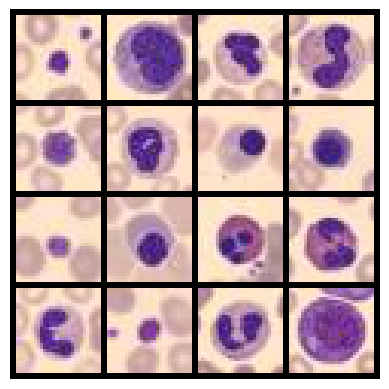

In [12]:
# visualization
# Get a few samples
samples = [full_dataset[i][0] for i in range(16)]  # assuming (image, label) tuples

# Make a grid
grid = make_grid(samples, nrow=4)

# Display
plt.imshow(to_pil_image(grid))
plt.axis('off')
plt.show()

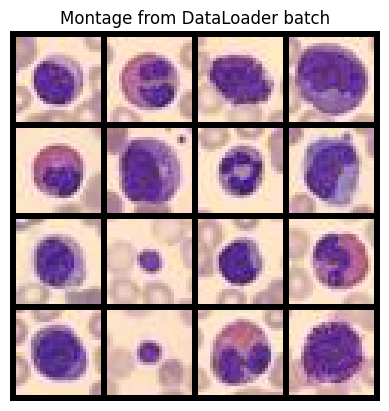

In [13]:
#Another option to visualize the dataset
data_iter = iter(dataloader)
images, labels = next(data_iter)  # get one batch

# Make grid
grid = make_grid(images[:16], nrow=4)  # you can adjust how many to show

# Display
plt.imshow(to_pil_image(grid))
plt.axis('off')
plt.title("Montage from DataLoader batch")
plt.show()

In [14]:
#assess image size
print(f"Image size: {images[0].shape}")

#assess label size
print(f"Label size: {labels[0].shape}")

#assess label values
s = set()
for i in range(len(labels)):
    s.add(labels[i].item())
print(f"Label values: {s}")

Image size: torch.Size([3, 28, 28])
Label size: torch.Size([1])
Label values: {0, 1, 2, 3, 4, 5, 6, 7}


<ipython-input-15-a9fa533cc9f3>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Class', y='Count', palette='viridis')


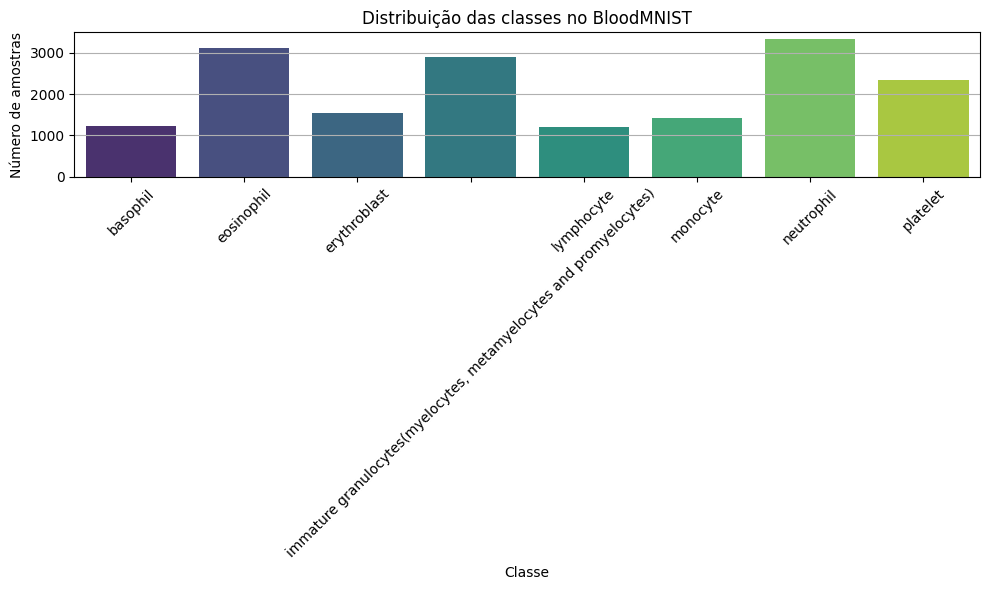

In [15]:
# Recolher todas as labels do full_dataset
all_labels = [label.item() for _, label in full_dataset]

# Contar frequência de cada label
label_counts = Counter(all_labels)

# Obter nomes das classes
class_names = [info['label'][str(i)] for i in range(n_classes)]

# Criar DataFrame
df = pd.DataFrame({
    'Class': [class_names[i] for i in range(n_classes)],
    'Count': [label_counts[i] if i in label_counts else 0 for i in range(n_classes)]
})

# Plotar gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Class', y='Count', palette='viridis')
plt.title('Distribuição das classes no BloodMNIST')
plt.xlabel('Classe')
plt.ylabel('Número de amostras')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 10000 random samples

In [16]:
# Fixar seed para reprodutibilidade (opcional)
random.seed(42)

# Índices aleatórios sem repetição
num_samples = 10_000
indices = random.sample(range(len(full_dataset)), num_samples)

# Subconjunto com 10.000 amostras reais
real_subset = Subset(full_dataset, indices)

# Dataloader para o subset real
real_loader = DataLoader(real_subset, batch_size=128, shuffle=False)

# Autoencoder

## Variational Autoencoder

In [17]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # -> (32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> (64, 7, 7)
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # -> (32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),  # -> (3, 28, 28)
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 64, 7, 7)
        return self.decoder_conv(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # ou 'mean' * batch_size
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def train_vae(model, dataloader, epochs=20, lr=1e-3, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            x = x * 2 - 1  # normalização para [-1, 1]

            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)
            loss = vae_loss(x_recon, x, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=64)
train_vae(vae, dataloader, epochs=20, lr=1e-3, device=device)


Epoch [1/20] - Loss: 234.3584
Epoch [2/20] - Loss: 129.5218
Epoch [3/20] - Loss: 108.6216
Epoch [4/20] - Loss: 98.5619
Epoch [5/20] - Loss: 93.6518
Epoch [6/20] - Loss: 91.1514
Epoch [7/20] - Loss: 89.3221
Epoch [8/20] - Loss: 88.0714
Epoch [9/20] - Loss: 87.0407
Epoch [10/20] - Loss: 86.1758
Epoch [11/20] - Loss: 85.4787
Epoch [12/20] - Loss: 84.8381
Epoch [13/20] - Loss: 84.2260
Epoch [14/20] - Loss: 83.7248
Epoch [15/20] - Loss: 83.1992
Epoch [16/20] - Loss: 82.8209
Epoch [17/20] - Loss: 82.3934
Epoch [18/20] - Loss: 82.1625
Epoch [19/20] - Loss: 81.8322
Epoch [20/20] - Loss: 81.4802


In [18]:
def generate_and_save_10000_vae(model, save_dir, latent_dim=64, batch_size=100, device='cpu'):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    num_samples = 10_000
    batches = num_samples // batch_size
    img_count = 0

    for _ in tqdm(range(batches), desc="Generating VAE images"):
        z = torch.randn(batch_size, latent_dim, device=device)
        with torch.no_grad():
            gen_imgs = model.decode(z)
            gen_imgs = (gen_imgs + 1) / 2  # convert from [-1,1] to [0,1]

        for i in range(batch_size):
            save_path = os.path.join(save_dir, f"{img_count + i:05}.png")
            save_image(gen_imgs[i], save_path)

        img_count += batch_size

output_dir_vae = "generated_vae"
generate_and_save_10000_vae(vae, output_dir_vae, latent_dim=64, device=device)

Generating VAE images: 100%|██████████| 100/100 [00:08<00:00, 11.70it/s]


# Generative Adversarial Networks

## DCGAN

In [19]:
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(DCGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512 * 7 * 7),
            nn.BatchNorm1d(512 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (512, 7, 7)),

            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # -> (256, 14, 14)
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1),    # -> (3, 28, 28)
            nn.Tanh()  # outputs in [-1, 1]
        )

    def forward(self, z):
        return self.model(z)


class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super(DCGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # -> (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # -> (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_dcgan(generator, discriminator, dataloader, latent_dim=100, epochs=50, lr=2e-4, device='cpu'):
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    criterion = nn.BCELoss()
    opt_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for imgs, _ in dataloader:
            real_imgs = imgs.to(device)
            real_imgs = real_imgs * 2 - 1  # Normalize to [-1, 1]
            batch_size = real_imgs.size(0)

            # Create labels
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # Train Discriminator
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z).detach()
            real_pred = discriminator(real_imgs)
            fake_pred = discriminator(fake_imgs)

            loss_real = criterion(real_pred, real_labels)
            loss_fake = criterion(fake_pred, fake_labels)
            loss_D = loss_real + loss_fake

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            # Train Generator
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_imgs = generator(z)
            pred = discriminator(gen_imgs)
            loss_G = criterion(pred, real_labels)  # Generator wants to fool the Discriminator

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
gen = DCGANGenerator(latent_dim)
disc = DCGANDiscriminator()

train_dcgan(gen, disc, dataloader, latent_dim=latent_dim, epochs=50, device=device)

Epoch [1/50] | D Loss: 0.1000 | G Loss: 4.3234
Epoch [2/50] | D Loss: 0.0459 | G Loss: 4.3163
Epoch [3/50] | D Loss: 0.0449 | G Loss: 5.3649
Epoch [4/50] | D Loss: 0.0042 | G Loss: 6.0330
Epoch [5/50] | D Loss: 0.0033 | G Loss: 6.4522
Epoch [6/50] | D Loss: 0.0017 | G Loss: 6.8240
Epoch [7/50] | D Loss: 0.0027 | G Loss: 7.1585
Epoch [8/50] | D Loss: 0.0019 | G Loss: 7.0353
Epoch [9/50] | D Loss: 0.0007 | G Loss: 7.4932
Epoch [10/50] | D Loss: 0.2240 | G Loss: 4.4205
Epoch [11/50] | D Loss: 0.0312 | G Loss: 4.5389
Epoch [12/50] | D Loss: 0.5470 | G Loss: 3.3519
Epoch [13/50] | D Loss: 0.1404 | G Loss: 7.4935
Epoch [14/50] | D Loss: 1.3402 | G Loss: 4.5553
Epoch [15/50] | D Loss: 0.0732 | G Loss: 3.3963
Epoch [16/50] | D Loss: 0.0583 | G Loss: 9.2865
Epoch [17/50] | D Loss: 0.4536 | G Loss: 3.8687
Epoch [18/50] | D Loss: 0.0334 | G Loss: 6.6904
Epoch [19/50] | D Loss: 0.0159 | G Loss: 5.4700
Epoch [20/50] | D Loss: 0.0167 | G Loss: 13.7127
Epoch [21/50] | D Loss: 0.0701 | G Loss: 3.6367


In [20]:
def generate_and_save_10000_dcgan(generator, save_dir, latent_dim=100, batch_size=100, device='cpu'):
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)

    num_samples = 10_000
    batches = num_samples // batch_size
    img_count = 0

    for _ in tqdm(range(batches), desc="Generating DCGAN images"):
        z = torch.randn(batch_size, latent_dim, device=device)
        with torch.no_grad():
            gen_imgs = generator(z)
            gen_imgs = (gen_imgs + 1) / 2  # Convert from [-1,1] to [0,1]

        for i in range(batch_size):
            save_path = os.path.join(save_dir, f"{img_count + i:05}.png")
            save_image(gen_imgs[i], save_path)

        img_count += batch_size

output_dir_dcgan = "generated_dcgan"
generate_and_save_10000_dcgan(gen, output_dir_dcgan, latent_dim=latent_dim, device=device)

Generating DCGAN images: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


# Diffusion Model

In [2]:
T = 1000
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, dim=0)


def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu()).float().to(t.device)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def forward_noise(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ab = get_index_from_list(torch.sqrt(alphas_bar), t, x0.shape)
    sqrt_one_minus_ab = get_index_from_list(torch.sqrt(1 - alphas_bar), t, x0.shape)
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise, noise


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=device) * -(math.log(10000) / half_dim))
        emb = t[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

class UNet(nn.Module):
    def __init__(self, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, 3, padding=1)

        self.time_to_feature = nn.Linear(time_dim, 128)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        t_feat = self.time_to_feature(t_emb).unsqueeze(-1).unsqueeze(-1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x) + t_feat)
        x = F.relu(self.conv3(x))
        return self.conv4(x)

def train_diffusion(model, dataloader, epochs=5, device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.to(device)
    model.train()

    for epoch in range(epochs):
        pbar = tqdm(dataloader)
        for x, _ in pbar:
            x = x.to(device)
            x = x * 2 - 1
            t = torch.randint(0, T, (x.shape[0],), device=device).long()

            x_noisy, noise = forward_noise(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")


@torch.no_grad()
def sample_diffusion(model, n=16, img_size=28, channels=3, device='cpu'):
    model.eval()
    x = torch.randn((n, channels, img_size, img_size), device=device)

    for t in reversed(range(T)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_tensor)

        alpha = alphas[t]
        alpha_bar = alphas_bar[t]
        beta = betas[t]

        coef1 = 1 / torch.sqrt(alpha)
        coef2 = (1 - alpha) / torch.sqrt(1 - alpha_bar)
        mean = coef1 * (x - coef2 * predicted_noise)

        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta)
            x = mean + sigma * noise
        else:
            x = mean

    x = (x + 1) / 2
    grid = make_grid(x.cpu(), nrow=4)
    plt.figure(figsize=(6, 6))
    plt.imshow(to_pil_image(grid))
    plt.axis('off')
    plt.title("Imagens geradas pelo Diffusion Model")
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(time_dim=128)

# Treinar
train_diffusion(model, dataloader, epochs=5, device=device)

NameError: name 'torch' is not defined

In [1]:
def generate_and_save_10000_diffusion(model, save_dir, batch_size=100, img_size=28, channels=3, device='cpu'):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    num_samples = 10_000
    batches = num_samples // batch_size
    img_count = 0

    for _ in tqdm(range(batches), desc="Generating diffusion images"):
        x = torch.randn((batch_size, channels, img_size, img_size), device=device)

        for t in reversed(range(T)):
            t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
            predicted_noise = model(x, t_tensor)

            alpha = alphas[t]
            alpha_bar = alphas_bar[t]
            beta = betas[t]

            coef1 = 1 / torch.sqrt(alpha)
            coef2 = (1 - alpha) / torch.sqrt(1 - alpha_bar)
            mean = coef1 * (x - coef2 * predicted_noise)

            if t > 0:
                noise = torch.randn_like(x)
                sigma = torch.sqrt(beta)
                x = mean + sigma * noise
            else:
                x = mean

        x = (x + 1) / 2
        for i in range(batch_size):
            save_path = os.path.join(save_dir, f"{img_count + i:05}.png")
            save_image(x[i], save_path)

        img_count += batch_size

generate_and_save_10000_diffusion(model, save_dir="generated_diffusion", device=device)

NameError: name 'model' is not defined

# Fréchet Inception Distance

In [ ]:
!pip install pytorch-fid

In [ ]:
import subprocess

def calculate_fid(path_real, path_fake):
    """
    Calcula o FID entre dois diretórios usando pytorch-fid via subprocess.
    """
    result = subprocess.run(
        ["python", "-m", "pytorch_fid", path_real, path_fake],
        capture_output=True,
        text=True
    )
    output = result.stdout
    return float(output.strip().split()[-1])

# Caminhos para os diretórios
path_real = "real_images"
paths_generated = {
    "VAE": "generated_vae",
    "DCGAN": "generated_dcgan",
    "DDPM": "generated_diffusion"
}

# Calcular e mostrar resultados
fid_scores = {}
for name, path_fake in paths_generated.items():
    fid = calculate_fid(path_real, path_fake)
    fid_scores[name] = fid
    print(f"FID {name}: {fid:.2f}")

# Mostrar resumo ordenado
print("\n📊 FID Score Comparison:")
for name, score in sorted(fid_scores.items(), key=lambda x: x[1]):
    print(f"{name}: {score:.2f}")
